In [1]:
import sys
from pathlib import Path
# Get the repository root (2 levels up from current notebook)
repo_root = Path(__file__).parent.parent.parent if '__file__' in globals() else Path.cwd().parent.parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import Template
# Definición de modulos
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling  import SMOTE, ADASYN
from sklearn.decomposition import PCA
from Mod_Productor3 import Mod_Productor as MP
# Instantiate the Template class


Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Datos1_InteraccionesNIR.xlsx')
# import the data from all sheets of the Excel file


df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15 = [
    pd.read_excel(data_path, sheet_name=i) for i in range(16)
]

In [2]:
# If the dataframes have any missing values on the 'Tratamiento' column, delete those rows
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15]):
    if df['Tratamiento'].isnull().any():
        df.dropna(subset=['Tratamiento'], inplace=True)
        print(f"Dropped missing 'Tratamiento' rows in df{i}")


Dropped missing 'Tratamiento' rows in df4
Dropped missing 'Tratamiento' rows in df10


In [3]:
# Lets add the column 'Sana' to all dataframes
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    # Index plants within each 'Tratamiento' category (starting from 1 for each category)
    if 'Planta' not in df.columns:
        plant_numbers = []
        for tratamiento in df['Tratamiento'].unique():
            category_mask = df['Tratamiento'] == tratamiento
            n_plants_in_category = category_mask.sum()
            # Create plant numbers from 1 to n for this category
            plant_numbers_for_category = list(range(1, n_plants_in_category + 1))
            
            # Add plant numbers in the correct order matching the dataframe rows
            for idx in df[category_mask].index:
                plant_numbers.append(plant_numbers_for_category.pop(0))
        
        df.insert(1, 'Planta', plant_numbers)
        print(f"df{i}: Added 'Planta' column by 'Tratamiento' categories")
        for tratamiento in df['Tratamiento'].unique():
            count = sum(df['Tratamiento'] == tratamiento)
            print(f"  {tratamiento}: {count} plants")
    
    # Now add 'Sana' and drop 'Tratamiento'
    df.insert(1, 'Sana', df['Tratamiento'].apply(lambda x: 1 if x == 'Control' else 0))
    df.drop(columns=['Tratamiento'], inplace=True)

# Now select 6 numbers at random from 1 to 30 for plant selection
np.random.seed(42)  # For reproducibility
selected_plants = np.random.choice(range(1, 31), size=6, replace=False)
print("Selected plants for analysis:", selected_plants)

# From the plants selected, lets remove the rows corresponding to those plants from 
# each dataframe and add them to a test dataframe
test_dfs = []
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    test_df = df[df['Planta'].isin(selected_plants)].copy()
    test_dfs.append(test_df)
    # Remove these rows from the original dataframe
    df.drop(index=test_df.index, inplace=True)
    print(f"df{i}: Moved {len(test_df)} rows to test set")

df0: Added 'Planta' column by 'Tratamiento' categories
  Control: 29 plants
  Ralstonia: 29 plants
  Fusarium: 30 plants
  E_Hidrico: 30 plants
  Ral_Fus: 27 plants
  Ral_EH: 30 plants
  Fus_EH_Ral: 30 plants
df1: Added 'Planta' column by 'Tratamiento' categories
  Control: 30 plants
  Ralstonia: 29 plants
  Fusarium: 30 plants
  E_Hidrico: 30 plants
  Ral_Fus: 30 plants
  Ral_EH: 30 plants
  Fus_EH: 30 plants
  Fus_EH_Ral: 30 plants
df2: Added 'Planta' column by 'Tratamiento' categories
  Control: 28 plants
  Ralstonia: 29 plants
  Fusarium: 29 plants
  E_Hidrico: 28 plants
  Ral_Fus: 29 plants
  Ral_EH: 30 plants
  Fus_EH: 30 plants
  Fus_EH_Ral: 30 plants
df3: Added 'Planta' column by 'Tratamiento' categories
  Control: 30 plants
  Ralstonia: 29 plants
  Fusarium: 30 plants
  E_Hidrico: 30 plants
  Ral_Fus: 30 plants
  Ral_EH: 30 plants
  Fus_EH: 28 plants
  Fus_EH_Ral: 30 plants
df4: Added 'Planta' column by 'Tratamiento' categories
  Control: 29 plants
  Ralstonia: 29 plants
  Fus

In [4]:
# Combine all test dataframes into one
test_df_combined = pd.concat(test_dfs, ignore_index=True)
print(f"Combined test dataframe has {len(test_df_combined)} rows")
test_df_combined.head(10)

Combined test dataframe has 710 rows


,Sana,Planta,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,1,9,0.070811,0.070708,0.068738,0.068142,0.068597,0.067998,0.063667,0.059101,...,0.039256,0.039099,0.038999,0.038921,0.038906,0.038806,0.038731,0.038589,0.038310,0.038163
1,1,10,0.060442,0.062362,0.056131,0.056657,0.058590,0.058558,0.055610,0.048597,...,0.036478,0.036378,0.036348,0.036202,0.035944,0.035785,0.035590,0.035508,0.035562,0.035471
2,1,16,0.065379,0.063930,0.063162,0.063767,0.063386,0.061034,0.057089,0.053973,...,0.041582,0.041465,0.041463,0.041288,0.040981,0.040747,0.040418,0.040234,0.040180,0.040011
3,1,18,0.071688,0.072464,0.073471,0.074896,0.074491,0.072490,0.070665,0.065283,...,0.036699,0.036554,0.036464,0.036364,0.036334,0.036298,0.036259,0.036150,0.036069,0.035952
4,1,24,0.054900,0.054559,0.051083,0.056556,0.060319,0.058287,0.052547,0.047870,...,0.040588,0.040373,0.040147,0.039938,0.039695,0.039485,0.039301,0.039135,0.038963,0.038863
5,1,28,0.053271,0.051633,0.052123,0.054103,0.055772,0.054979,0.050029,0.046028,...,0.030300,0.030244,0.030310,0.030322,0.030469,0.030398,0.030161,0.030035,0.029861,0.029700
6,0,9,0.053605,0.055537,0.052248,0.053043,0.055501,0.056639,0.054097,0.051775,...,0.040385,0.040199,0.040167,0.040076,0.040050,0.039880,0.039575,0.039500,0.039465,0.039387
7,0,10,0.060120,0.058686,0.053795,0.060766,0.065724,0.064453,0.060873,0.055807,...,0.037167,0.036991,0.036826,0.036664,0.036537,0.036375,0.036186,0.036041,0.035898,0.035776
8,0,16,0.038046,0.040249,0.038693,0.043328,0.046173,0.044545,0.040426,0.035936,...,0.042807,0.042631,0.042359,0.042219,0.042159,0.042039,0.041955,0.041859,0.041688,0.041660
9,0,18,0.030751,0.031507,0.028468,0.032771,0.037119,0.037244,0.032353,0.026213,...,0.043566,0.043312,0.043028,0.042847,0.042702,0.042565,0.042508,0.042396,0.042265,0.042135


In [5]:
# Finally, we can drop the 'Planta' column from all dataframes 
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    if 'Planta' in df.columns:
        df.drop(columns=['Planta'], inplace=True)

In [6]:
test_df_combined.head()

,Sana,Planta,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,1,9,0.070811,0.070708,0.068738,0.068142,0.068597,0.067998,0.063667,0.059101,...,0.039256,0.039099,0.038999,0.038921,0.038906,0.038806,0.038731,0.038589,0.038310,0.038163
1,1,10,0.060442,0.062362,0.056131,0.056657,0.058590,0.058558,0.055610,0.048597,...,0.036478,0.036378,0.036348,0.036202,0.035944,0.035785,0.035590,0.035508,0.035562,0.035471
2,1,16,0.065379,0.063930,0.063162,0.063767,0.063386,0.061034,0.057089,0.053973,...,0.041582,0.041465,0.041463,0.041288,0.040981,0.040747,0.040418,0.040234,0.040180,0.040011
3,1,18,0.071688,0.072464,0.073471,0.074896,0.074491,0.072490,0.070665,0.065283,...,0.036699,0.036554,0.036464,0.036364,0.036334,0.036298,0.036259,0.036150,0.036069,0.035952
4,1,24,0.054900,0.054559,0.051083,0.056556,0.060319,0.058287,0.052547,0.047870,...,0.040588,0.040373,0.040147,0.039938,0.039695,0.039485,0.039301,0.039135,0.038963,0.038863


In [7]:
# Produce the models for each dataframe
models = {}
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    print(f"Producing model for DataFrame df{i}...")
    modelo = MP(df, target = 'Sana', test_size=0.2, random_state=42, PCA_components=3)
    modelo.train_model()
    models[f'model_df{i}'] = modelo

Producing model for DataFrame df0...
Original feature count: 2151
Features after PCA: 3
Explained variance ratio: [0.71896583 0.19673246 0.03345956]
Total explained variance: 0.9492

Class distribution before SMOTE:
  Class 0 (Unhealthy): 141
  Class 1 (Healthy): 23

Class distribution after SMOTE:
  Class 0 (Unhealthy): 141
  Class 1 (Healthy): 141

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

TRAINING COMPLETE
Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.6980
  Precision: 0.7013
  Recall: 0.7655
  F1-Score: 0.7223
  ROC-AUC: 0.7507
Producing model for DataFrame df1...
Original feature count: 2151
Features after PCA: 3
Explained variance ratio: [0.61817439 0.21692074 0.06129582]
Total explained variance: 0.8964

Class distribution before SMOTE:
  Class 0 (Unhealthy): 167
  Class 1 (Healthy): 24

Class distribution after SMOTE:
  Class 0 (Unheal

c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TRAINING COMPLETE
Best parameters found:  {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.9966
  Precision: 0.9935
  Recall: 1.0000
  F1-Score: 0.9967
  ROC-AUC: 1.0000
Producing model for DataFrame df8...
Original feature count: 2151
Features after PCA: 3
Explained variance ratio: [0.94633178 0.0336419  0.01334591]
Total explained variance: 0.9933

Class distribution before SMOTE:
  Class 0 (Unhealthy): 143
  Class 1 (Healthy): 24

Class distribution after SMOTE:
  Class 0 (Unhealthy): 143
  Class 1 (Healthy): 143

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TRAINING COMPLETE
Best parameters found:  {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.8570
  Precision: 0.8131
  Recall: 0.9438
  F1-Score: 0.8707
  ROC-AUC: 0.9005
Producing model for DataFrame df9...
Original feature count: 2151
Features after PCA: 3
Explained variance ratio: [0.94107036 0.02857301 0.02140862]
Total explained variance: 0.9911

Class distribution before SMOTE:
  Class 0 (Unhealthy): 167
  Class 1 (Healthy): 24

Class distribution after SMOTE:
  Class 0 (Unhealthy): 167
  Class 1 (Healthy): 167

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

TRAINING COMPLETE
Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

Best scores across all metrics:
  Accuracy: 0.8237
  Precision: 0.8205
  Recall: 0.8922
  F1-Score: 0.8444
  ROC-AUC: 0.8838
Producing model for DataFrame df10...
Original feature count: 2151
Features

c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TRAINING COMPLETE
Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.8983
  Precision: 0.8633
  Recall: 0.9638
  F1-Score: 0.9077
  ROC-AUC: 0.9332
Producing model for DataFrame df11...
Original feature count: 2151
Features after PCA: 3
Explained variance ratio: [0.87570019 0.09444337 0.02078759]
Total explained variance: 0.9909

Class distribution before SMOTE:
  Class 0 (Unhealthy): 159
  Class 1 (Healthy): 24

Class distribution after SMOTE:
  Class 0 (Unhealthy): 159
  Class 1 (Healthy): 159

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

TRAINING COMPLETE
Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

Best scores across all metrics:
  Accuracy: 0.8684
  Precision: 0.8316
  Recall: 0.9437
  F1-Score: 0.8807
  ROC-AUC: 0.9090
Producing model for DataFrame df12...
Original feature count: 2151
Featu

c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TRAINING COMPLETE
Best parameters found:  {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.8931
  Precision: 0.8697
  Recall: 0.9379
  F1-Score: 0.8998
  ROC-AUC: 0.9617
Producing model for DataFrame df14...
Original feature count: 2151
Features after PCA: 3
Explained variance ratio: [0.95941289 0.02839493 0.00773278]
Total explained variance: 0.9955

Class distribution before SMOTE:
  Class 0 (Unhealthy): 143
  Class 1 (Healthy): 24

Class distribution after SMOTE:
  Class 0 (Unhealthy): 143
  Class 1 (Healthy): 143

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

TRAINING COMPLETE
Best parameters found:  {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.8641
  Precision: 0.8175
  Recall: 1.0000
  F1-Score: 0.8914
  ROC-AUC: 0.8808
Producing model for DataFrame df15...
Original feature count: 2151
Features 

In [8]:
# First make a prediction on the test samples with ALL models
df_predictions = test_df_combined.copy()

df_predictions.drop(columns=['Planta'], errors='ignore', inplace=True)


# For each model, make predictions on ALL test samples
for model_num in range(0, 16):
    modelo = models[f'model_df{model_num}']
    
    # Prepare all test data (removing 'Sana' and 'Day' columns, keeping only wavelength features)
    feature_columns = [col for col in df_predictions.columns if col not in ['Sana', 'Day'] and not str(col).startswith('pred_')]
    X_test_all = df_predictions[feature_columns].values
    
    # Make predictions with this model on all test samples
    y_pred = modelo.predict(X_test_all)
    
    # Add predictions as a new column
    df_predictions[f'pred_{model_num}'] = y_pred
    print(f"Model {model_num} predictions added to column 'pred_{model_num}'")


# Display the first few rows
print("\nFirst few rows of predictions:")
print(df_predictions.head())

# Save the predictions to a CSV file
df_predictions.to_csv('predictions.csv', index=False)
print("\nPredictions saved to 'predictions.csv'")

# Show column names to verify
print("\nColumns in df_predictions:")
print(df_predictions.columns.tolist())

Model 0 predictions added to column 'pred_0'
Model 1 predictions added to column 'pred_1'
Model 2 predictions added to column 'pred_2'
Model 3 predictions added to column 'pred_3'
Model 4 predictions added to column 'pred_4'
Model 5 predictions added to column 'pred_5'
Model 6 predictions added to column 'pred_6'
Model 7 predictions added to column 'pred_7'
Model 8 predictions added to column 'pred_8'
Model 9 predictions added to column 'pred_9'
Model 10 predictions added to column 'pred_10'
Model 11 predictions added to column 'pred_11'
Model 12 predictions added to column 'pred_12'
Model 13 predictions added to column 'pred_13'
Model 14 predictions added to column 'pred_14'
Model 15 predictions added to column 'pred_15'

First few rows of predictions:
   Sana       350       351       352       353       354       355       356  \
0     1  0.070811  0.070708  0.068738  0.068142  0.068597  0.067998  0.063667   
1     1  0.060442  0.062362  0.056131  0.056657  0.058590  0.058558  0.055

In [9]:
# Drop the columns of the wavelength features
df_predictions.drop(columns=feature_columns, inplace=True)

In [10]:
df_predictions.head(10)


,Sana,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15
0,1,1,0,0,0,1,0,1,0,1,1,1,1,1,1,1,1
1,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1
2,1,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1
3,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1
4,1,1,1,0,0,1,1,1,0,1,0,0,0,1,0,1,1
5,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1
6,0,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1
7,0,0,0,0,0,0,0,1,0,1,1,0,1,1,1,1,1
8,0,1,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1
9,0,1,1,0,0,1,1,1,0,1,0,0,0,1,0,1,1


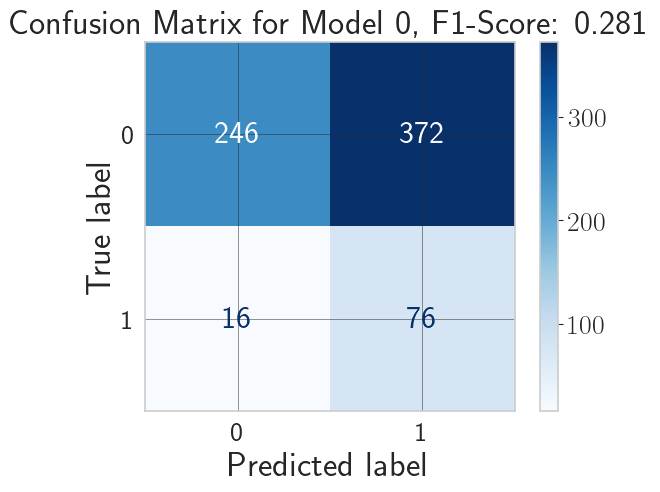

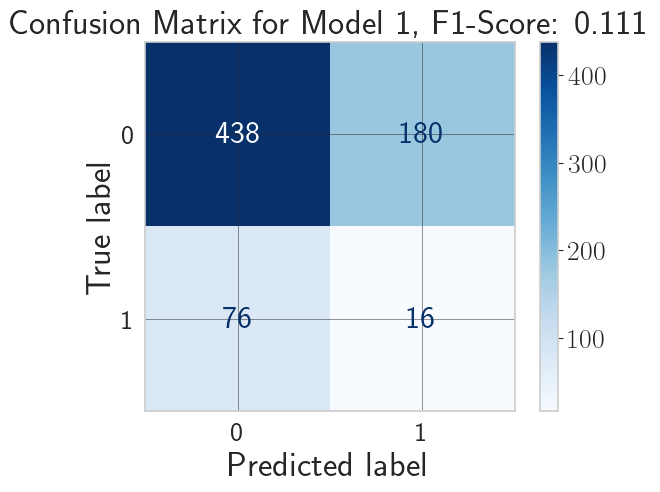

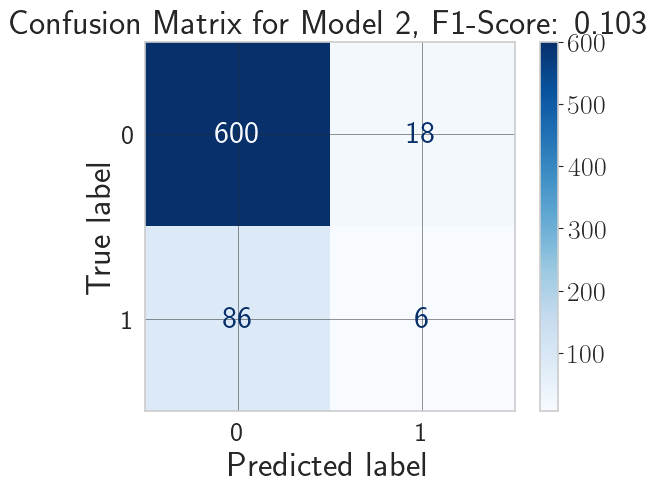

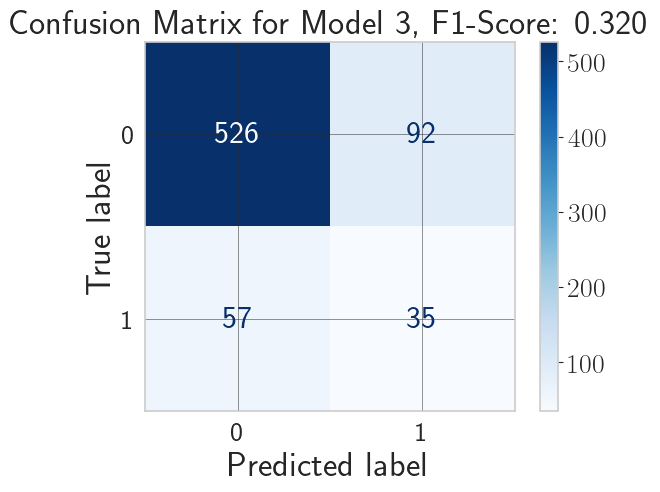

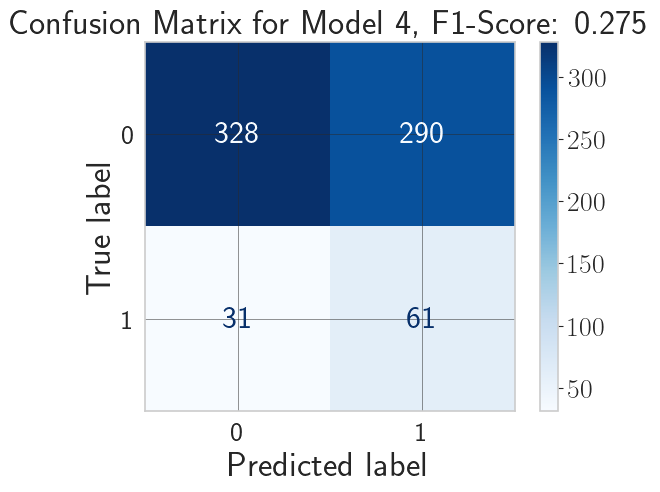

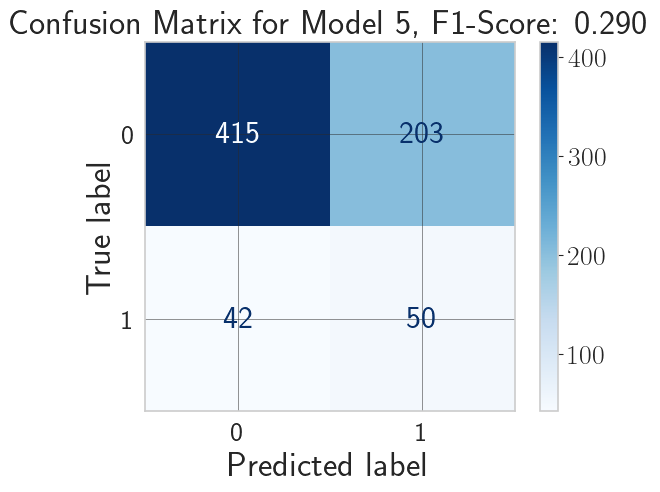

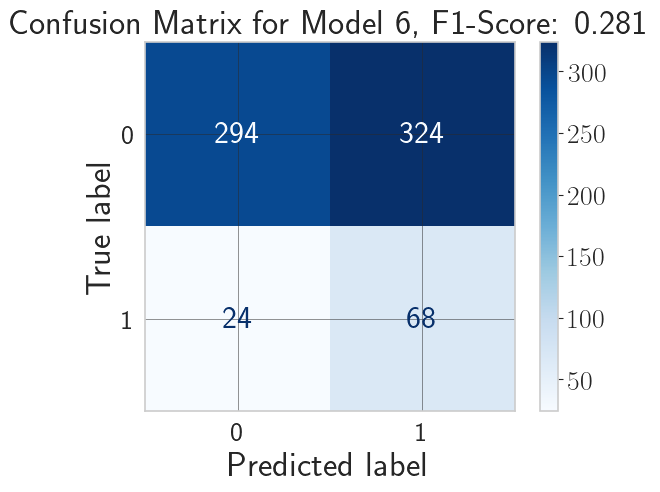

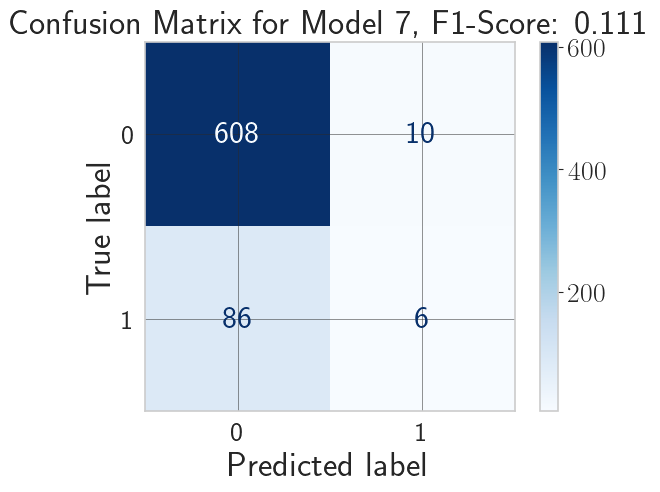

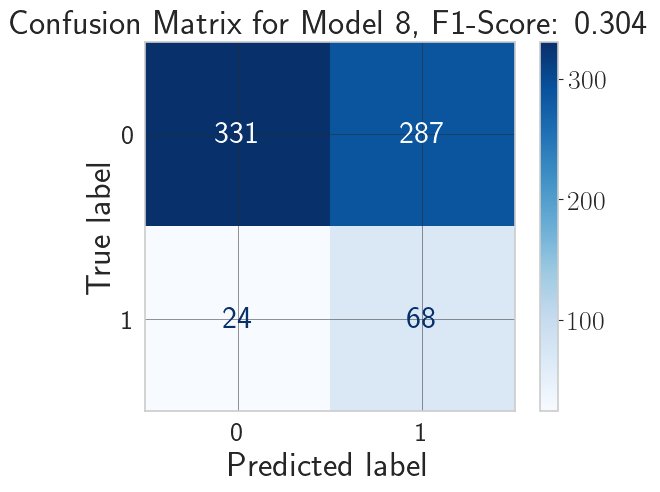

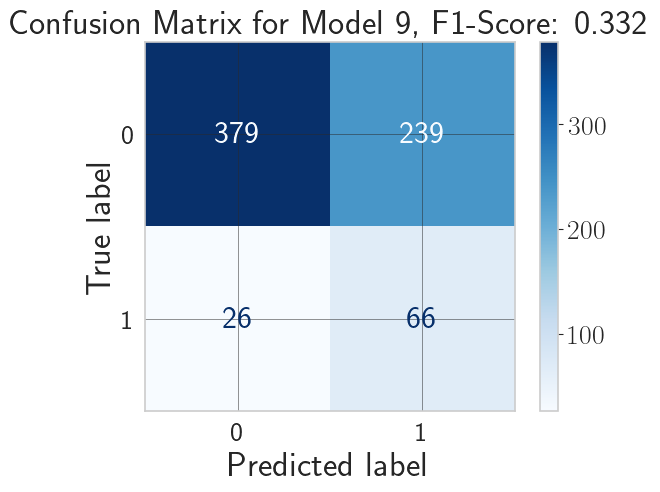

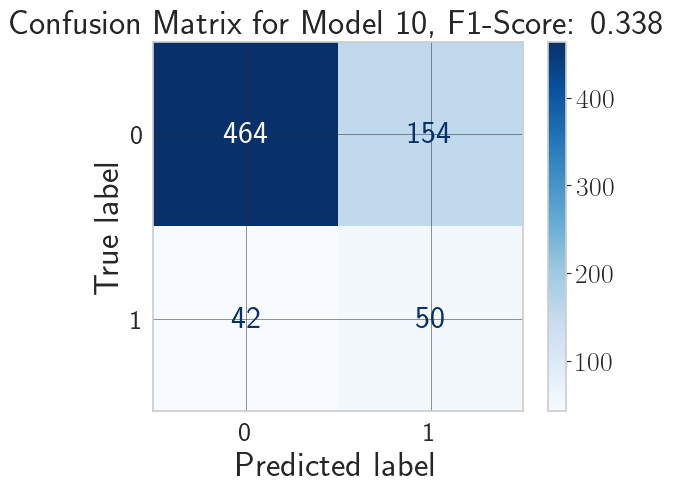

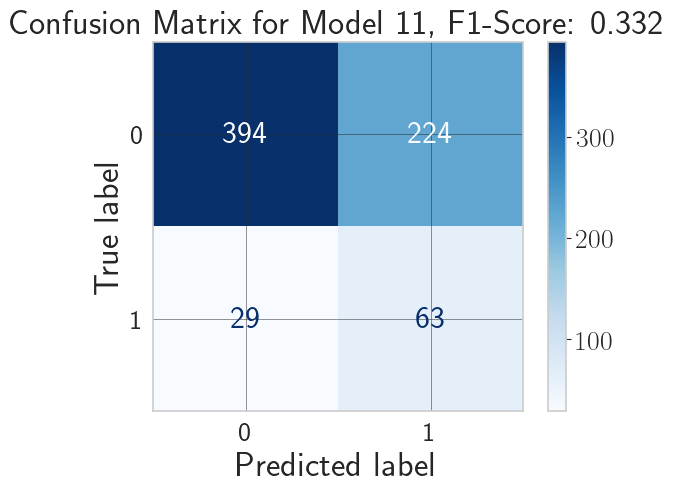

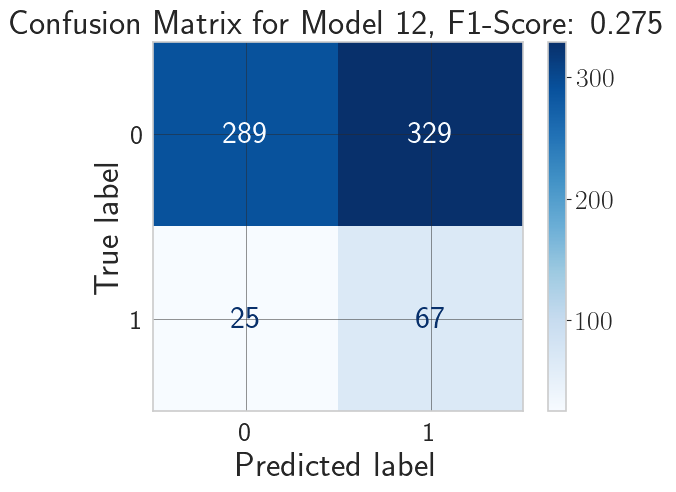

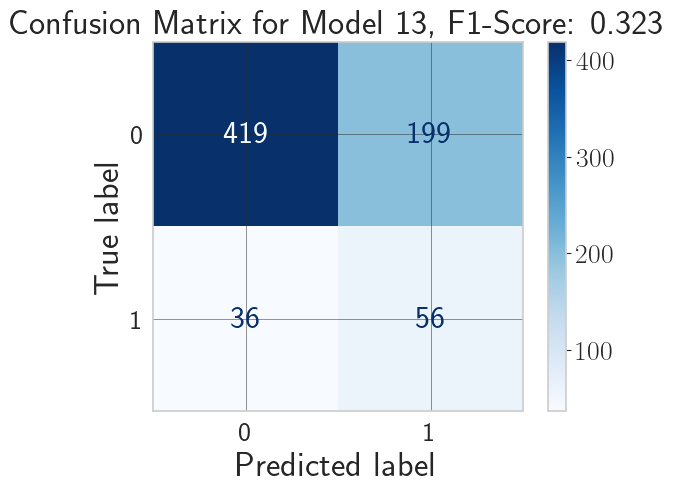

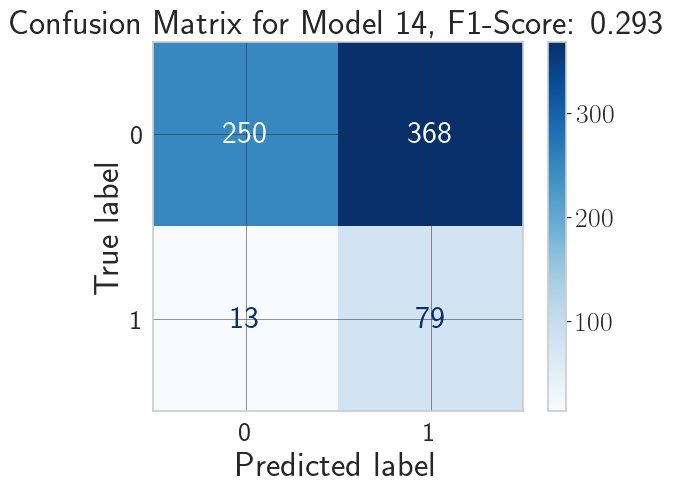

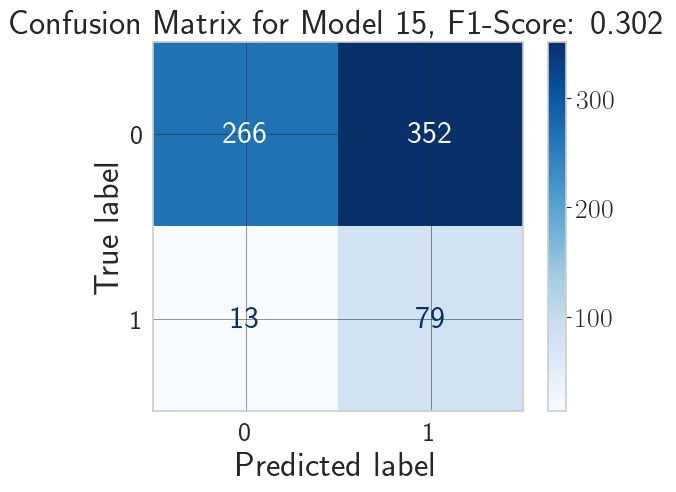

In [11]:
# Confussion matrix for each model
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import f1_score
for model_num in range(0, 16):
    y_true = df_predictions['Sana'].values
    y_pred = df_predictions[f'pred_{model_num}'].values
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    # plot confusion matrix with title corresponding to model number
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=plt.cm.Blues)
    # Set title and add accuracy in the title
    f1 = f1_score(y_true, y_pred)
    disp.ax_.set_title(f'Confusion Matrix for Model {model_num}, F1-Score: {f1:.3f}')
    plt.show()